In [1]:
from utility import *

# GPUs Available:  1


In [2]:
#load the data
data_size = 1000
X_train, Y_train, X_validation, Y_validation, X_test = load_data(data_size)

# defining the parameters

# loss
# Mean Squared Error
# Root Mean Squared Error
# Mean Absolute Error
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
batch_size = 32
epochs = 100
# steps_per_epoch = sum(train_occurences) / batch_size
starter_learning_rate = 1e-1
end_learning_rate = 1e-8
decay_steps = epochs * 3
# loss = tf.keras.losses.MeanAbsoluteError()
# loss = tf.keras.losses.MeanSquaredError()
# loss = 'mean_squared_error'
metrics = tf.keras.metrics.MeanSquaredError()
scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate= starter_learning_rate,
    decay_steps= decay_steps,
    end_learning_rate= end_learning_rate,
    power=1)
# scheduler = 0.01
# optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler)
kernel_regularizer=tf.keras.regularizers.L1L2(0.01)
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error',patience=20)]
initializer=tf.keras.initializers.HeUniform(seed = 22)

verbose=2

# generating augmented data
X_train_Aug, Y_train_Aug = data_augmentation(X_train, Y_train)

1000 rowed data loaded


In [3]:
class Hidden_layer(layers.Layer):
    def __init__(self,units, **kwargs):
        super(Hidden_layer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(name = 'w',shape=(input_shape[-1],self.units), initializer=tf.keras.initializers.HeUniform(seed = 22),
                                 trainable=True, regularizer=tf.keras.regularizers.L1L2(0.01))

    def call(self, inputs):
        x = tf.keras.activations.relu(tf.matmul(inputs, self.W))
        return x
    def get_config(self):
        config = super(Hidden_layer, self).get_config()
        config.update({"units": self.units})
        # config.update({"initializer": initializer})
        # config.update({"kernel_regularizer": kernel_regularizer})
        return config
        # return {"units": self.units, "kernel_regularizer": kernel_regularizer, "initializer": initializer}
    # @classmethod
    # def from_config(cls, config):
    #     return cls(**config)
        
class Output_layer(layers.Layer):
    def __init__(self, units, **kwargs):
        super(Output_layer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(name = 'w',shape=(input_shape[-1],self.units), initializer=tf.keras.initializers.HeUniform(seed = 22),
                                 trainable=True, regularizer=tf.keras.regularizers.L1L2(0.01))

    def call(self, inputs):
        x = tf.matmul(inputs, self.W)
        return tf.keras.activations.tanh(x)
    def get_config(self):
        config = super(Output_layer, self).get_config()
        config.update({"units": self.units})
        # config.update({"initializer": initializer})
        # config.update({"kernel_regularizer": kernel_regularizer})
        return config
        # return {"units": self.units, "kernel_regularizer": kernel_regularizer, "initializer": initializer}
    # @classmethod
    # def from_config(cls, config):
    #     return cls(**config)

# class MyReLU(layers.Layer):
#     def __init__(self):
#         super(MyReLU, self).__init__()

#     def call(self, x):
#         return tf.math.maximum(x, 0)

In [4]:
# NN Model 
class NNmodel():
    def model():
        model = tf.keras.models.Sequential()
        model.add(Hidden_layer(4))
        model.add(Output_layer(2))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
                    loss = [tf.keras.losses.MeanAbsoluteError()],
                    metrics = tf.keras.metrics.MeanSquaredError()
        )
        return model

Epoch 1/100
32/32 - 2s - loss: 0.5260 - mean_squared_error: 0.2926 - val_loss: 0.4184 - val_mean_squared_error: 0.1710 - 2s/epoch - 59ms/step
Epoch 2/100
32/32 - 0s - loss: 0.3292 - mean_squared_error: 0.0600 - val_loss: 0.2940 - val_mean_squared_error: 0.0224 - 185ms/epoch - 6ms/step
Epoch 3/100
32/32 - 0s - loss: 0.2735 - mean_squared_error: 0.0225 - val_loss: 0.2967 - val_mean_squared_error: 0.0274 - 205ms/epoch - 6ms/step
Epoch 4/100
32/32 - 0s - loss: 0.2617 - mean_squared_error: 0.0195 - val_loss: 0.2573 - val_mean_squared_error: 0.0183 - 141ms/epoch - 4ms/step
Epoch 5/100
32/32 - 0s - loss: 0.2610 - mean_squared_error: 0.0201 - val_loss: 0.2677 - val_mean_squared_error: 0.0203 - 181ms/epoch - 6ms/step
Epoch 6/100
32/32 - 0s - loss: 0.2590 - mean_squared_error: 0.0193 - val_loss: 0.2638 - val_mean_squared_error: 0.0191 - 148ms/epoch - 5ms/step
Epoch 7/100
32/32 - 0s - loss: 0.2582 - mean_squared_error: 0.0188 - val_loss: 0.2844 - val_mean_squared_error: 0.0259 - 176ms/epoch - 6ms

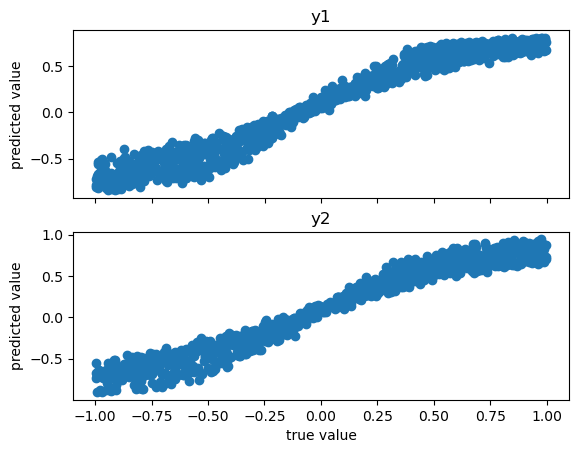

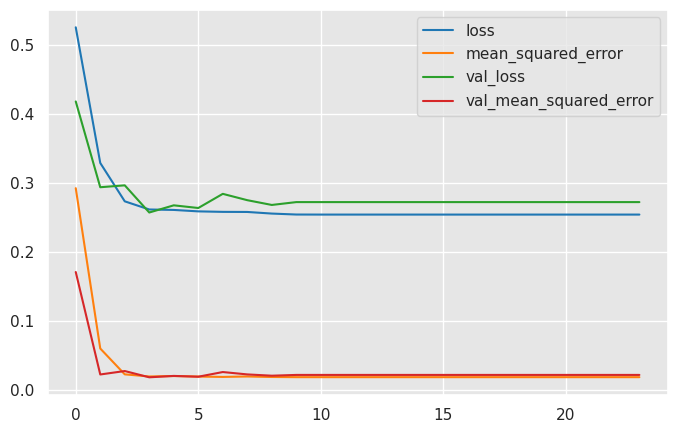

1/1 [==============================] - 0s 16ms/step
[[ 0.10180008  0.09703327]
 [-0.29198962  0.47068799]
 [-0.28839972 -0.31113256]
 [ 0.46607773 -0.30613459]
 [ 0.46300366  0.47497712]
 [-0.46383529  0.61552042]
 [ 0.60847409 -0.48007504]
 [-0.52467266  0.66430711]
 [ 0.60847409 -0.48007504]
 [-0.45920775 -0.48642616]]


In [5]:
# Model 1 - NN fitting with Normal data
model = NNmodel.model()
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size= batch_size, 
                    verbose=verbose, 
                    validation_data=(X_validation, Y_validation),
                    callbacks=callbacks,
                    # shuffle=True
                    )  
model_eval(model, history, X_validation, Y_validation, X_train, Y_train, batch_size, X_test)
model.save('./models/NN_1000_normal.h5')

32/32 [==============================] - 0s 824us/step
rmse of y1:  0.1495496957088629
rmse of y2:  0.14514593735752152
1/1 [==============================] - 0s 16ms/step
[[ 0.10180008  0.09703327]
 [-0.29198962  0.47068799]
 [-0.28839972 -0.31113256]
 [ 0.46607773 -0.30613459]
 [ 0.46300366  0.47497712]
 [-0.46383529  0.61552042]
 [ 0.60847409 -0.48007504]
 [-0.52467266  0.66430711]
 [ 0.60847409 -0.48007504]
 [-0.45920775 -0.48642616]]


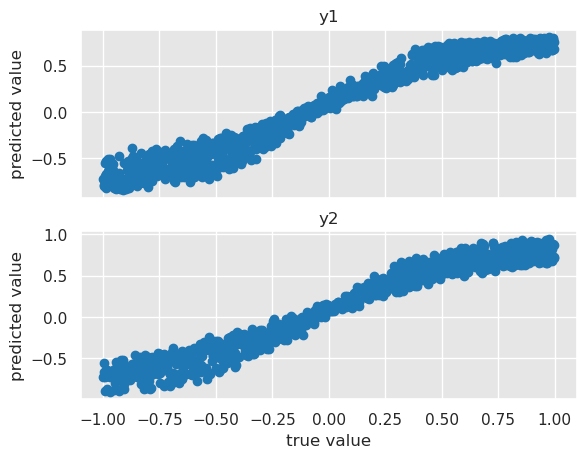

In [6]:
model.get_config()
# models = ['NN_1000_normal.h5','NN_1000_Aug.h5','ENN_1000_normal.h5','ENN_1000_Aug.h5', ]
# for model in models:
from keras.utils import CustomObjectScope

with CustomObjectScope({'Hidden_layer':Hidden_layer, 'Output_layer':Output_layer}):
       #soln 1
       # load_model = tf.keras.models.load_model('NN_1000_normal.h5', compile=False)
       load_model = tf.keras.models.load_model('./models/NN_1000_normal.h5')
       
predictions = load_model.predict(X_validation)
prediction_accuracy(predictions, Y_validation)
evaluate_train = load_model.evaluate(X_train, Y_train, batch_size=batch_size)

# evaluate_train = model.evaluate(X_train, Y_train, batch_size=batch_size)
evaluate_validation = load_model.evaluate(X_validation,Y_validation, batch_size=batch_size)

y_pred = load_model.predict(X_test)
print(y_pred)

Epoch 1/100
250/250 - 1s - loss: 0.3263 - mean_squared_error: 0.0720 - val_loss: 0.2582 - val_mean_squared_error: 0.0197 - 725ms/epoch - 3ms/step
Epoch 2/100
250/250 - 0s - loss: 0.2778 - mean_squared_error: 0.0272 - val_loss: 0.2507 - val_mean_squared_error: 0.0185 - 405ms/epoch - 2ms/step
Epoch 3/100
250/250 - 0s - loss: 0.2777 - mean_squared_error: 0.0271 - val_loss: 0.2507 - val_mean_squared_error: 0.0185 - 385ms/epoch - 2ms/step
Epoch 4/100
250/250 - 0s - loss: 0.2777 - mean_squared_error: 0.0271 - val_loss: 0.2507 - val_mean_squared_error: 0.0185 - 440ms/epoch - 2ms/step
Epoch 5/100
250/250 - 0s - loss: 0.2777 - mean_squared_error: 0.0271 - val_loss: 0.2507 - val_mean_squared_error: 0.0185 - 353ms/epoch - 1ms/step
Epoch 6/100
250/250 - 0s - loss: 0.2777 - mean_squared_error: 0.0271 - val_loss: 0.2507 - val_mean_squared_error: 0.0185 - 408ms/epoch - 2ms/step
Epoch 7/100
250/250 - 1s - loss: 0.2777 - mean_squared_error: 0.0271 - val_loss: 0.2507 - val_mean_squared_error: 0.0185 - 5

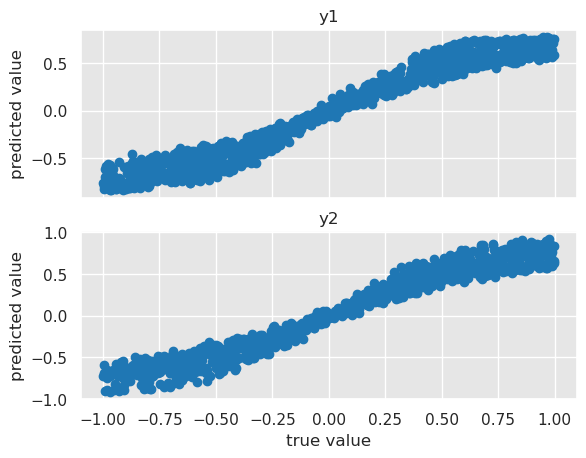

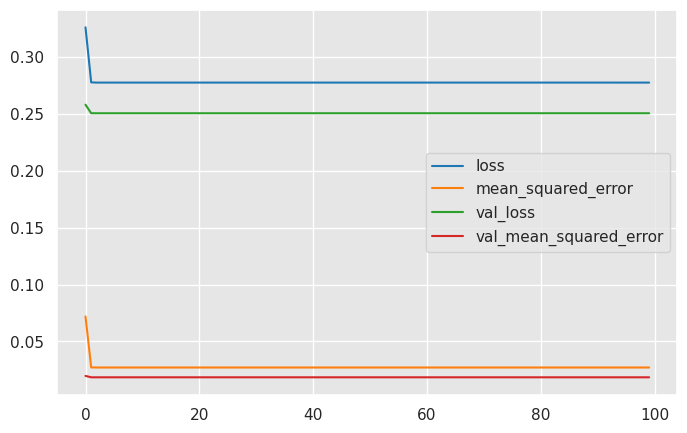

1/1 [==============================] - 0s 21ms/step
[[-0.00391453  0.00123437]
 [-0.36499102  0.37804947]
 [-0.3663854  -0.37126809]
 [ 0.35818559 -0.37593158]
 [ 0.3595879   0.37339459]
 [-0.51681977  0.53423691]
 [ 0.51105864 -0.53247044]
 [-0.57014267  0.588498  ]
 [ 0.51105864 -0.53247044]
 [-0.51858711 -0.52662028]]


In [7]:
# Model 2 - NN fitting with Augmented data

model = NNmodel.model()
history = model.fit(X_train_Aug, Y_train_Aug,
                    epochs=epochs, 
                    batch_size= batch_size, 
                    verbose=verbose, 
                    validation_data=(X_validation, Y_validation),
                    callbacks=callbacks,
                    # shuffle=True
                    )  
model_eval(model, history, X_validation, Y_validation, X_train_Aug, Y_train_Aug, batch_size, X_test)
model.save('./models/NN_1000_Aug.h5')

32/32 [==============================] - 0s 1ms/step
rmse of y1:  0.1394622805060166
rmse of y2:  0.13244200815671867
1/1 [==============================] - 0s 24ms/step
[[-0.00391453  0.00123437]
 [-0.36499102  0.37804947]
 [-0.3663854  -0.37126809]
 [ 0.35818559 -0.37593158]
 [ 0.3595879   0.37339459]
 [-0.51681977  0.53423691]
 [ 0.51105864 -0.53247044]
 [-0.57014267  0.588498  ]
 [ 0.51105864 -0.53247044]
 [-0.51858711 -0.52662028]]


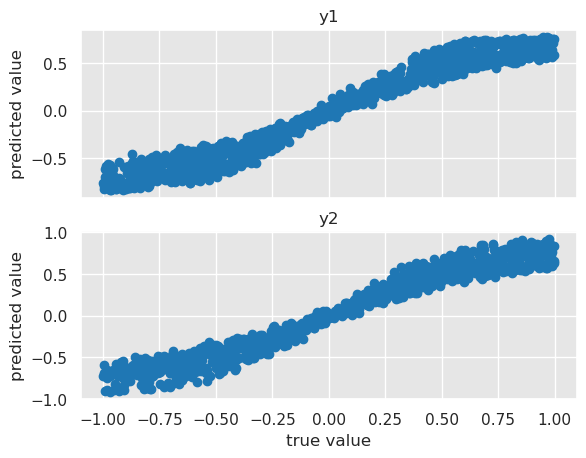

In [8]:
model.get_config()
# models = ['NN_1000_normal.h5','NN_1000_Aug.h5','ENN_1000_normal.h5','ENN_1000_Aug.h5', ]
# for model in models:
from keras.utils import CustomObjectScope

with CustomObjectScope({'Hidden_layer':Hidden_layer, 'Output_layer':Output_layer}):
       #soln 1
       # load_model = tf.keras.models.load_model('NN_1000_normal.h5', compile=False)
       load_model = tf.keras.models.load_model('./models/NN_1000_Aug.h5')
       
predictions = load_model.predict(X_validation)
prediction_accuracy(predictions, Y_validation)
evaluate_train = load_model.evaluate(X_train_Aug, Y_train_Aug, batch_size=batch_size)

# evaluate_train = model.evaluate(X_train, Y_train, batch_size=batch_size)
evaluate_validation = load_model.evaluate(X_validation,Y_validation, batch_size=batch_size)

y_pred = load_model.predict(X_test)
print(y_pred)

In [9]:
class EqHidden_layer(layers.Layer):
    def __init__(self, units, **kwargs):
        super(EqHidden_layer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.a = self.add_weight(name = 'a',shape=(1,), initializer=tf.keras.initializers.HeUniform(seed = 22),
                                 trainable=True, regularizer=tf.keras.regularizers.L1L2(0.01))
        self.b = self.add_weight(name = 'b',shape=(1,), initializer=tf.keras.initializers.HeUniform(seed = 22),
                                 trainable=True, regularizer=tf.keras.regularizers.L1L2(0.01))
        self.c = self.add_weight(name = 'c',shape=(1,), initializer=tf.keras.initializers.HeUniform(seed = 22),
                                 trainable=True, regularizer=tf.keras.regularizers.L1L2(0.01))
        self.a_matrix = tf.constant([[1,0,0,0], [0,1,0,0], [0,0,1,0],[0,0,0,1]], dtype=tf.float64)
        self.b_matrix = tf.constant([[0,1,0,1], [1,0,1,0], [0,1,0,1],[1,0,1,0]], dtype=tf.float64)
        self.c_matrix = tf.constant([[0,0,1,0], [0,0,0,1], [1,0,0,0],[0,1,0,0]], dtype=tf.float64)
    
    def call(self, inputs):
        self.W = tf.multiply(self.a, self.a_matrix) + tf.multiply(self.b, self.b_matrix) + tf.multiply(self.c, self.c_matrix)
        x = tf.keras.activations.relu(tf.matmul(inputs, self.W))
        # tf.print(self.W)
        return x
    def get_config(self):
        config = super(EqHidden_layer, self).get_config()
        config.update({"units": self.units})
        # config.update({"initializer": initializer})
        # config.update({"kernel_regularizer": kernel_regularizer})
        return config
    # @classmethod
    # def from_config(cls, config):
    #     return cls(**config)

class EqOutput_layer(layers.Layer):
    def __init__(self,units, **kwargs):
        super(EqOutput_layer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.d = self.add_weight(name = 'd',shape=(1,), initializer=tf.keras.initializers.HeUniform(seed = 22),
                                 trainable=True, regularizer=tf.keras.regularizers.L1L2(0.01))
        self.d_matrix = tf.constant([[1,-1], [-1,-1], [-1,1],[1,1]], dtype=tf.float64)

    def call(self, inputs):
        self.W = tf.multiply(self.d, self.d_matrix)
        x = tf.matmul(inputs, self.W)
        # tf.print(tf.transpose(self.W))
        return tf.keras.activations.tanh(x)
    def get_config(self):
        config = super(EqOutput_layer, self).get_config()
        config.update({"units": self.units})
        # config.update({"initializer": initializer})
        # config.update({"kernel_regularizer": kernel_regularizer})
        return config

    # @classmethod
    # def from_config(cls, config):
    #     return cls(**config)

In [10]:
# Equivariant NN Model
class EqNNmodel():
    def model():
        model = tf.keras.models.Sequential()
        model.add(EqHidden_layer(4))
        model.add(EqOutput_layer(2))

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
                    loss = tf.keras.losses.MeanAbsoluteError(),
                    metrics = tf.keras.metrics.MeanSquaredError()
        )
        return model

Epoch 1/100
32/32 - 1s - loss: 0.4001 - mean_squared_error: 0.2203 - val_loss: 0.2060 - val_mean_squared_error: 0.0386 - 833ms/epoch - 26ms/step
Epoch 2/100
32/32 - 0s - loss: 0.1685 - mean_squared_error: 0.0274 - val_loss: 0.1257 - val_mean_squared_error: 0.0132 - 145ms/epoch - 5ms/step
Epoch 3/100
32/32 - 0s - loss: 0.1545 - mean_squared_error: 0.0223 - val_loss: 0.1270 - val_mean_squared_error: 0.0136 - 133ms/epoch - 4ms/step
Epoch 4/100
32/32 - 0s - loss: 0.1548 - mean_squared_error: 0.0217 - val_loss: 0.1236 - val_mean_squared_error: 0.0134 - 131ms/epoch - 4ms/step
Epoch 5/100
32/32 - 0s - loss: 0.1535 - mean_squared_error: 0.0214 - val_loss: 0.1264 - val_mean_squared_error: 0.0136 - 123ms/epoch - 4ms/step
Epoch 6/100
32/32 - 0s - loss: 0.1540 - mean_squared_error: 0.0216 - val_loss: 0.1242 - val_mean_squared_error: 0.0131 - 123ms/epoch - 4ms/step
Epoch 7/100
32/32 - 0s - loss: 0.1530 - mean_squared_error: 0.0207 - val_loss: 0.1215 - val_mean_squared_error: 0.0120 - 129ms/epoch - 

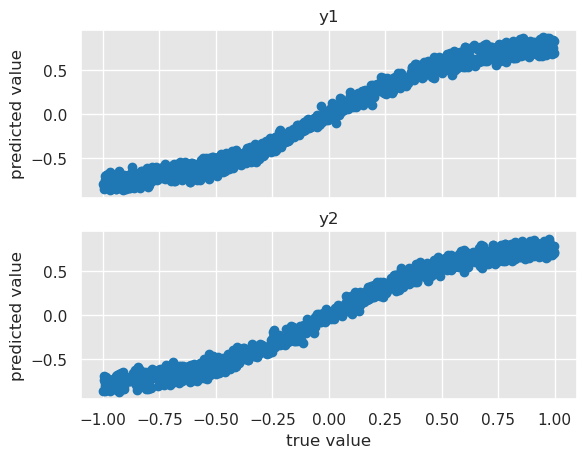

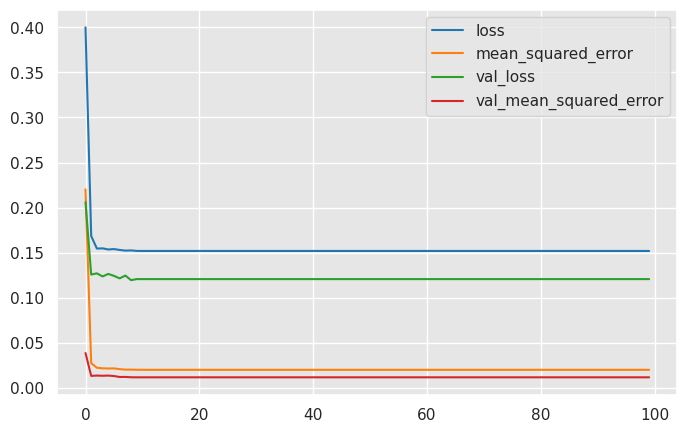

1/1 [==============================] - 0s 22ms/step
[[ 0.          0.        ]
 [-0.42835474  0.42835474]
 [-0.42835474 -0.42835474]
 [ 0.42835474 -0.42835474]
 [ 0.42835474  0.42835474]
 [-0.53371571  0.53371571]
 [ 0.53371571 -0.53371571]
 [-0.57187539  0.57187539]
 [ 0.53371571 -0.53371571]
 [-0.53371571 -0.53371571]]


In [11]:
# Model 3 Equivariant NN - on Normal data
Eqmodel = EqNNmodel.model()
history = Eqmodel.fit(X_train, Y_train,
                    epochs=epochs, 
                    batch_size= batch_size, 
                    verbose=verbose, 
                    validation_data=(X_validation, Y_validation),
                    callbacks=callbacks,
                    # shuffle=True
                    )  
model_eval(Eqmodel, history, X_validation, Y_validation, X_train, Y_train, batch_size, X_test)
Eqmodel.save('./models/ENN_1000_normal.h5',
          overwrite=True)

32/32 [==============================] - 0s 2ms/step
rmse of y1:  0.11030102993281649
rmse of y2:  0.10575880798428046
1/1 [==============================] - 0s 26ms/step
[[ 0.          0.        ]
 [-0.42835474  0.42835474]
 [-0.42835474 -0.42835474]
 [ 0.42835474 -0.42835474]
 [ 0.42835474  0.42835474]
 [-0.53371571  0.53371571]
 [ 0.53371571 -0.53371571]
 [-0.57187539  0.57187539]
 [ 0.53371571 -0.53371571]
 [-0.53371571 -0.53371571]]


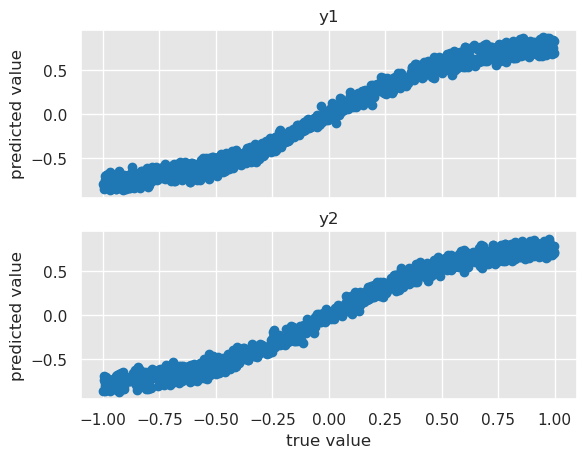

In [12]:
model.get_config()
# models = ['NN_1000_normal.h5','NN_1000_Aug.h5','ENN_1000_normal.h5','ENN_1000_Aug.h5', ]
# for model in models:
from keras.utils import CustomObjectScope

with CustomObjectScope({'EqHidden_layer':EqHidden_layer, 'EqOutput_layer':EqOutput_layer}):
       #soln 1
       # load_model = tf.keras.models.load_model('NN_1000_normal.h5', compile=False)
       load_model = tf.keras.models.load_model('./models/ENN_1000_normal.h5')
       
predictions = load_model.predict(X_validation)
prediction_accuracy(predictions, Y_validation)
evaluate_train = load_model.evaluate(X_train, Y_train, batch_size=batch_size)

# evaluate_train = model.evaluate(X_train, Y_train, batch_size=batch_size)
evaluate_validation = load_model.evaluate(X_validation,Y_validation, batch_size=batch_size)

y_pred = load_model.predict(X_test)
print(y_pred)

Epoch 1/100
250/250 - 1s - loss: 0.1836 - mean_squared_error: 0.0468 - val_loss: 0.1255 - val_mean_squared_error: 0.0152 - 909ms/epoch - 4ms/step
Epoch 2/100
250/250 - 0s - loss: 0.1523 - mean_squared_error: 0.0228 - val_loss: 0.1255 - val_mean_squared_error: 0.0150 - 430ms/epoch - 2ms/step
Epoch 3/100
250/250 - 0s - loss: 0.1522 - mean_squared_error: 0.0228 - val_loss: 0.1255 - val_mean_squared_error: 0.0150 - 438ms/epoch - 2ms/step
Epoch 4/100
250/250 - 0s - loss: 0.1522 - mean_squared_error: 0.0228 - val_loss: 0.1255 - val_mean_squared_error: 0.0150 - 392ms/epoch - 2ms/step
Epoch 5/100
250/250 - 0s - loss: 0.1522 - mean_squared_error: 0.0228 - val_loss: 0.1255 - val_mean_squared_error: 0.0150 - 450ms/epoch - 2ms/step
Epoch 6/100
250/250 - 1s - loss: 0.1522 - mean_squared_error: 0.0228 - val_loss: 0.1255 - val_mean_squared_error: 0.0150 - 581ms/epoch - 2ms/step
Epoch 7/100
250/250 - 1s - loss: 0.1522 - mean_squared_error: 0.0228 - val_loss: 0.1255 - val_mean_squared_error: 0.0150 - 5

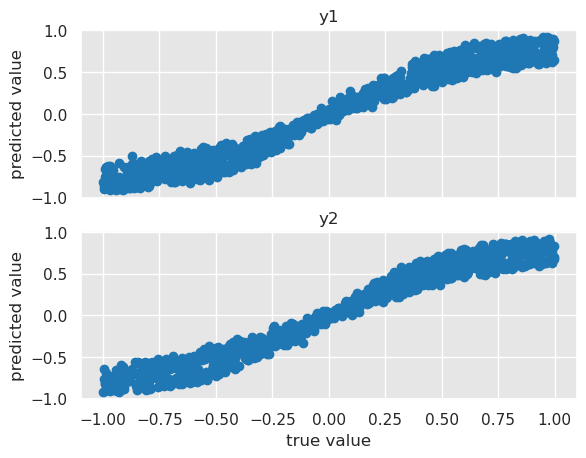

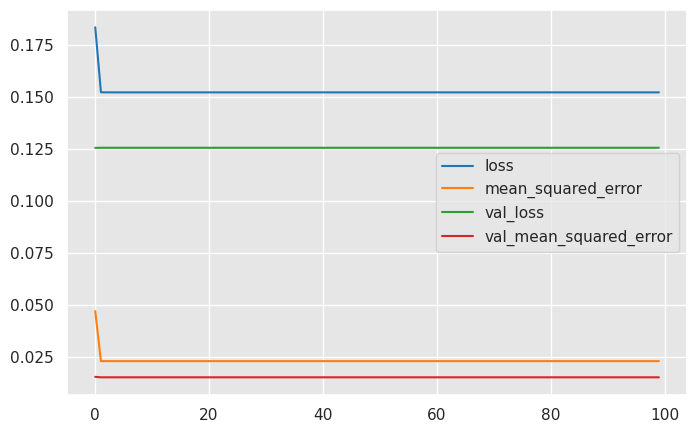

1/1 [==============================] - 0s 27ms/step
[[ 0.          0.        ]
 [-0.4042181   0.4042181 ]
 [-0.4042181  -0.4042181 ]
 [ 0.4042181  -0.4042181 ]
 [ 0.4042181   0.4042181 ]
 [-0.56695297  0.56695297]
 [ 0.56695297 -0.56695297]
 [-0.62230435  0.62230435]
 [ 0.56695297 -0.56695297]
 [-0.56695297 -0.56695297]]


In [13]:
# Model 4 Equivariant NN - on Augmented data
model = EqNNmodel.model()
history = model.fit(X_train_Aug, Y_train_Aug,
                    epochs=epochs, 
                    batch_size= batch_size, 
                    verbose=verbose, 
                    validation_data=(X_validation, Y_validation),
                    callbacks=callbacks,
                    # shuffle=True
                    )  
model_eval(model, history, X_validation, Y_validation, X_train_Aug, Y_train_Aug, batch_size, X_test)
model.save('./models/ENN_1000_Aug.h5')

32/32 [==============================] - 0s 1ms/step
rmse of y1:  0.12585491554575984
rmse of y2:  0.1188157923198492
1/1 [==============================] - 0s 25ms/step
[[ 0.          0.        ]
 [-0.4042181   0.4042181 ]
 [-0.4042181  -0.4042181 ]
 [ 0.4042181  -0.4042181 ]
 [ 0.4042181   0.4042181 ]
 [-0.56695297  0.56695297]
 [ 0.56695297 -0.56695297]
 [-0.62230435  0.62230435]
 [ 0.56695297 -0.56695297]
 [-0.56695297 -0.56695297]]


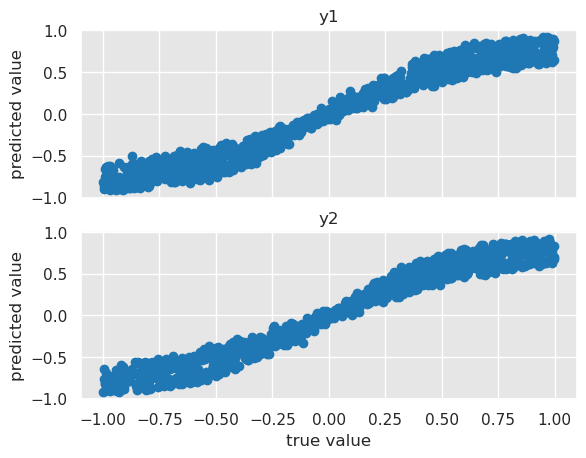

In [14]:
model.get_config()
# models = ['NN_1000_normal.h5','NN_1000_Aug.h5','ENN_1000_normal.h5','ENN_1000_Aug.h5', ]
# for model in models:
from keras.utils import CustomObjectScope

with CustomObjectScope({'EqHidden_layer':EqHidden_layer, 'EqOutput_layer':EqOutput_layer}):
       #soln 1
       # load_model = tf.keras.models.load_model('NN_1000_normal.h5', compile=False)
       load_model = tf.keras.models.load_model('./models/ENN_1000_Aug.h5')
       
predictions = load_model.predict(X_validation)
prediction_accuracy(predictions, Y_validation)
evaluate_train = load_model.evaluate( X_train_Aug, Y_train_Aug, batch_size=batch_size)

# evaluate_train = model.evaluate(X_train, Y_train, batch_size=batch_size)
evaluate_validation = load_model.evaluate(X_validation,Y_validation, batch_size=batch_size)

y_pred = load_model.predict(X_test)
print(y_pred)